# Assignment #4 :Final project

Taketo Muroya

**Instruction (Option 2):** Use a dataset of interest to you to build machine learning models and then compare predictions of at least three models on test data. A number of you have expressed interest and put in the time to gather (or find) your own data and to implement the modelling approaches we have studied to analyze this data. This assignment will give you the opportunity to write up what you have found in this process. Please be sure to decribe your dataset (including the features, target, and the general type of data you are working with). Describe each model you will run. Then compare results. Please save your jupyter notebook to an html file and upload it to this assignment to complete your final report.

In [1]:
# Import packages
import re
import os
import sys
import requests
import MeCab
import oseti
import urllib
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
import tensorflow as tf
import seaborn as sns

from math import sqrt
from bs4 import BeautifulSoup
from pathlib import Path
from subprocess import call
from wordcloud import WordCloud
from keras.regularizers import l2
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

Using TensorFlow backend.


## Introduction

This report tries to nowcast the Index of Business Conditions (IBC) using the Monthly Report of Prospects for Japan’s Economy (MRPJE). The IBC represents the Japanese economic conditions over time. The MRPJE is an economic report published by Japan Research Institute (a private company). If the MRPJE is written well about the Japanese economic conditions, it should nowcast the IBC with a high performance.

## Set up Target variable

Use the IBC data from Jan. 2009 to Feb. 2020 (134 observations)

In [2]:
# load the IBC data
# https://www.esri.cao.go.jp/en/stat/di/di-e.html
ibc = pd.read_csv('data/Indexes of Business Conditions.csv', index_col=0)
ibc = ibc.iloc[288:]

# set time-series format
ibc.to_csv("temp.csv")
dateparse = lambda dates: pd.datetime.strptime(dates, '%b-%y')
ibc = pd.read_csv('temp.csv', index_col=0, date_parser=dateparse, dtype='float')

ibc

,Coincident Index
time,
2009-01-01,75.3
2009-02-01,69.9
2009-03-01,69.2
2009-04-01,70.3
2009-05-01,72.2
...,...
2019-10-01,96.1
2019-11-01,95.1
2019-12-01,94.3


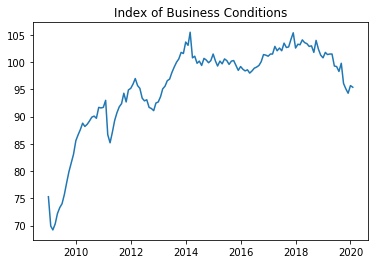

In [87]:
# visualize IBC
plt.plot(ibc['Coincident Index'])
plt.title('Index of Business Conditions')
plt.savefig("images/ibc.png")

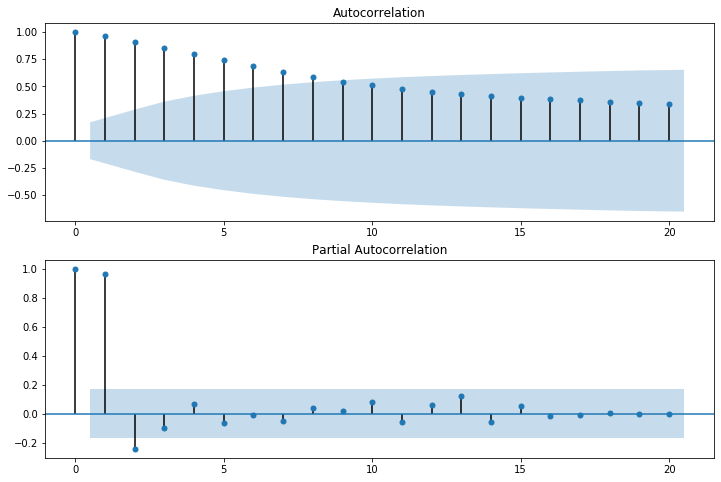

In [4]:
# Check Autocorrelation of IBC

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ibc['Coincident Index'], lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ibc['Coincident Index'], lags=20, ax=ax2)
plt.savefig("images/autocorrelation.png")

Since the IBC is a time-series data, it has a autocorrelation. To deal with this issue, this report mainly selects the Recurrent Neural Network (RNN) models

## Set up predictors

Use Monthly Report of Prospects for Japan’s Economy (MRPJE) from Jan. 2009 to Feb. 2020 (134 observations) as predictors, which are written in Japanese

### Web scraping

In [5]:
"""

# Get URLs of each report
JRI = str()
for word in ["2009","2010","2011","2012","2013","2014",
             "2015","2016","2017","2018","2019","2020"]:
    JRI += str('https://www.jri.co.jp/report/medium/japan/' + word + '/ ')
page = JRI.split()
page = sorted(page)

url_list = []
for p in page:
    content = requests.get(p)
    soup = BeautifulSoup(content.text, 'html.parser')
    tmp = str(soup.findAll(href=re.compile("pdf")))
    pattern4 = "/file/report/japan/pdf/[0-9]{4}.pdf"
    pattern5 = "/file/report/japan/pdf/[0-9]{5}.pdf"
    tmp_url = re.findall(pattern4, tmp) + re.findall(pattern5, tmp)
    url_list += tmp_url

W = str()
for word in url_list:
    W += str('https://www.jri.co.jp' + word + ' ')
url = W.split()

# Download reports as pdf foramt and transform them into dataframe
df = pd.DataFrame()
for i in range(0,137):
    urllib.request.urlretrieve(url[i],'tmp.pdf')
    py_path = Path(sys.exec_prefix) / "Scripts" / "pdf2txt.py"
    call(["py", str(py_path), "-otmp.txt", "tmp.pdf"])
    tmp_data = open("tmp.txt", "r", encoding="utf-8")
    contents = tmp_data.read()
    contents = contents.replace('\n', '')
    contents = contents.replace('\x0c', '')
    contents = contents.replace(' ', '')
    head = contents[6:13]
    tmp = pd.DataFrame([contents], index={head}, columns={'body'})
    df = df.append(tmp)
    tmp_data.close()

# Arrange the order of reports chronologically
dfj = pd.DataFrame()
dfj = dfj.append(df.iloc[[11,10,9,8,7,6,5,4,3,2,1,0],:])
dfj = dfj.append(df.iloc[[23,22,21,20,19,18,17,16,15,14,13,12],:])
dfj = dfj.append(df.iloc[[35,34,33,32,31,30,29,28,27,26,25,24],:])
dfj = dfj.append(df.iloc[[47,46,45,44,43,42,41,40,39,38,37,36],:])
dfj = dfj.append(df.iloc[[59,58,57,56,55,54,53,52,51,50,49,48],:])
dfj = dfj.append(df.iloc[[71,70,69,68,67,66,65,64,63,62,61,60],:])
dfj = dfj.append(df.iloc[[83,82,81,80,79,78,77,76,75,74,73,72],:])
dfj = dfj.append(df.iloc[[95,94,93,92,91,90,89,88,87,86,85,84],:])
dfj = dfj.append(df.iloc[[101,100,99,98,97,96,108,107,106,105,104,103],:])
dfj = dfj.append(df.iloc[[102,120,119,118,117,116,115,114,113,112,111,110],:])
dfj = dfj.append(df.iloc[[109,132,131,130,129,128,127,126,125,124,123,122],:])
dfj = dfj.append(df.iloc[[121,136],:])

dfj.to_csv("data/text.csv")

"""

'\n\n# Get URLs of each report\nJRI = str()\nfor word in ["2009","2010","2011","2012","2013","2014",\n             "2015","2016","2017","2018","2019","2020"]:\n    JRI += str(\'https://www.jri.co.jp/report/medium/japan/\' + word + \'/ \')\npage = JRI.split()\npage = sorted(page)\n\nurl_list = []\nfor p in page:\n    content = requests.get(p)\n    soup = BeautifulSoup(content.text, \'html.parser\')\n    tmp = str(soup.findAll(href=re.compile("pdf")))\n    pattern4 = "/file/report/japan/pdf/[0-9]{4}.pdf"\n    pattern5 = "/file/report/japan/pdf/[0-9]{5}.pdf"\n    tmp_url = re.findall(pattern4, tmp) + re.findall(pattern5, tmp)\n    url_list += tmp_url\n\nW = str()\nfor word in url_list:\n    W += str(\'https://www.jri.co.jp\' + word + \' \')\nurl = W.split()\n\n# Download reports as pdf foramt and transform them into dataframe\ndf = pd.DataFrame()\nfor i in range(0,137):\n    urllib.request.urlretrieve(url[i],\'tmp.pdf\')\n    py_path = Path(sys.exec_prefix) / "Scripts" / "pdf2txt.py"\n   

In [6]:
dfj = pd.read_csv("data/text.csv", index_col=0)
dfj

,body
２００９年１月,日本経済展望２００９年１月調査部 マクロ経済研究センターhttp://www.jri.co....
２００９年２月,日本経済展望２００９年２月調査部 マクロ経済研究センターhttp://www.jri.co....
２００９年３月,日本経済展望２００９年３月調査部 マクロ経済研究センターhttp://www.jri.co....
２００９年４月,日本経済展望２００９年４月調査部 マクロ経済研究センターhttp://www.jri.co....
２００９年５月,日本経済展望２００９年５月調査部 マクロ経済研究センターhttp://www.jri.co....
...,...
２０１９年１０,日本経済展望２０１９年１０月 調査部マクロ経済研究センターhttp://www.jri...
２０１９年１１,日本経済展望２０１９年１１月 調査部マクロ経済研究センターhttp://www.jri...
２０１９年１２,日本経済展望２０１９年１２月 調査部マクロ経済研究センターhttp://www.jri...
２０２０年１月,日本経済展望２０２０年１月 調査部マクロ経済研究センターhttp://www.jri....


### Sentiment Analysis

Sentiment analysis is useful to examine the simple trend of the text data

In [7]:
# https://qiita.com/yukinoi/items/46aa016d83bb0e64f598
sentiment = oseti.Analyzer()

# create sentiment index for economic reports
sent = pd.DataFrame()
for i in range(0,134):
    sen = pd.DataFrame(sentiment.count_polarity(dfj.body[i]))
    pos = sum(sen.positive)
    neg = sum(sen.negative)
    score = (pos-neg)/(pos+neg)
    tmp1 = pd.DataFrame([pos], index={ibc.index[i]}, columns={'positive'})
    tmp2 = pd.DataFrame([neg], index={ibc.index[i]}, columns={'negative'})
    tmp3 = pd.DataFrame([score], index={ibc.index[i]}, columns={'sentiment'})
    tmp = pd.concat([tmp1, tmp2, tmp3], axis=1)
    sent = sent.append(tmp)

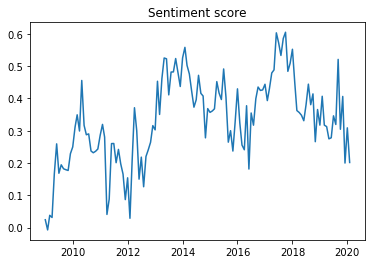

In [8]:
# visualize sentiment index
plt.plot(sent.sentiment)
plt.title('Sentiment score')
plt.savefig("images/sentiment.png")

The shape of sentiment score is roughly similar to the IBC

In [9]:
# check correlation
cor = ibc['Coincident Index'].corr(sent.sentiment)
print("Correlation between sentiment score and IBC: {:.2f}".format(cor))

Correlation between sentiment score and IBC: 0.70


### Pre-processing

To use the text data from the MRPJE as predictors, Natural Language Processing is necessary

In [10]:
# Eliminate useless words and adjust text size
clean = pd.DataFrame()
for i in range(0,134):
    text = re.sub('[ ]+', '' , dfj.body[i]) #0-9１-９％円台年月日いるなっところられ
    new_text = text[:round(len(text)*1)] # use 100% of text
    tmp = pd.DataFrame([new_text], index={ibc.index[i]}, columns={'body'})
    clean = clean.append(tmp)

# Define the Morphological Analysis function for Japanese
# Extract only nouns, verbs, adjectives, and adjective verbs
def split_text(text):
    tagger = MeCab.Tagger()
    words = []
    for c in tagger.parse(text).splitlines()[:-1]:
        surface, feature = c.split('\t')
        pos = feature.split(',')[0]
        if pos=='名詞' or pos=='動詞' or pos=='形容詞' or pos=='形容動詞':
            words.append(surface)
    return ' '.join(words)

# Split texts in reports into words
split = pd.DataFrame()
for i in range(0,134):
    text = split_text(clean.body[i])
    tmp = pd.DataFrame([text], index={ibc.index[i]}, columns={'body'})
    split = split.append(tmp)

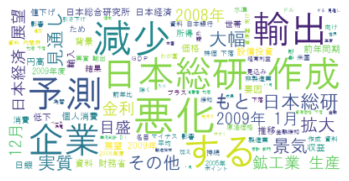

In [11]:
# Set up and draw the word cloud
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", 
                      font_path='HGRGM.TTC').generate(split.body[0])
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
wordcloud.to_file("images/wordcloud.png")

The word could shows economic words, such as export, decrease, expansion, and production

## Method 1: Tf-Idf Vectorizer

To transform the text data from the MRPJE, this report uses the Tf-idf vectorizer as method 1 and the word embedding as method 2

In [12]:
# TfidfVectorizer
vec_tfidf = TfidfVectorizer(ngram_range=(1, 3), min_df=5, norm=None)
xform_tfidf = vec_tfidf.fit_transform(split.body).toarray()
col_names = vec_tfidf.get_feature_names()
xform_tfidf = pd.DataFrame(xform_tfidf, index=ibc.index, columns=col_names)

xform_tfidf.tail()

,00,00 00,00 00 00,00 00 40,00 00 41,00 01,00 01 3１,00 02,00 03,00 04,...,ﾕｰﾛ ヵ月 10年,ﾗｸﾞ,ﾗｸﾞ 次数,ﾗｸﾞ 次数 ols,ﾚｰﾄ,ﾚｰﾄ com,ﾚｰﾄ com gsci,ﾛｼｱ,ﾛｼｱ 豪州,ﾛｼｱ 豪州 中南米
time,,,,,,,,,,,,,,,,,,,,,
2019-10-01,8.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,2.855876,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-11-01,8.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,2.855876,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-01,9.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,2.855876,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01,16.0,5.921672,0.0,0.0,0.0,0.0,0.0,3.825833,0.0,3.825833,...,2.855876,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-01,14.0,5.921672,0.0,0.0,0.0,0.0,0.0,3.825833,0.0,3.825833,...,2.855876,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# Define PCA function
def iterate_var(var_target):
    var_fig = 0.0
    cnt = 1
    while var_fig <= var_target:
        pca = PCA(n_components=cnt)
        dim = pca.fit_transform(xform_tfidf)
        var_fig = sum(pca.explained_variance_ratio_) 
        cnt += 1
    return dim, pca

# Set explained variance
dim, pca = iterate_var(0.5)
dim_j = pd.DataFrame(dim, index=ibc.index)

dim_j.tail()

,0,1,2,3,4,5,6
time,,,,,,,
2019-10-01,-29.826746,159.462290,116.346435,-43.289380,-69.447736,19.059965,-11.227102
2019-11-01,-27.898796,152.783693,114.235361,-39.280411,-68.179372,21.948054,-11.972601
2019-12-01,-25.728440,148.310132,108.227791,-39.247961,-65.144782,24.969989,-9.781198
2020-01-01,-25.601532,144.544650,104.255241,-34.285396,-60.290927,21.027986,-6.620104
2020-02-01,-20.669564,141.173857,102.069478,-35.115345,-60.829891,19.731396,-10.046923


Since the number of variables in vectors is too large, this code condenses them into 7 variables using PCA

### Nowcasting using RNN models

In [14]:
# set a target and features
features = pd.concat([ibc.iloc[:,0], dim_j], axis=1)
features.tail()

,Coincident Index,0,1,2,3,4,5,6
time,,,,,,,,
2019-10-01,96.1,-29.826746,159.462290,116.346435,-43.289380,-69.447736,19.059965,-11.227102
2019-11-01,95.1,-27.898796,152.783693,114.235361,-39.280411,-68.179372,21.948054,-11.972601
2019-12-01,94.3,-25.728440,148.310132,108.227791,-39.247961,-65.144782,24.969989,-9.781198
2020-01-01,95.7,-25.601532,144.544650,104.255241,-34.285396,-60.290927,21.027986,-6.620104
2020-02-01,95.4,-20.669564,141.173857,102.069478,-35.115345,-60.829891,19.731396,-10.046923


In [15]:
# set training percentage
TRAIN_SPLIT = round(0.8*len(features))
print(TRAIN_SPLIT)

# feature scaling
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

107


In [16]:
def multivariate_data(dataset, target, start_index, end_index, 
                      history_size, target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    # add current dataset
    indices = range(i-history_size, i+1, step)
    temp = pd.DataFrame(dataset[indices])
    # replace current target to previous one
    temp.iat[history_size, 0] = temp.iat[history_size-1, 0]
    data.append(np.array(temp))

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [17]:
# create training and test data
past_history = 6
future_target = 0
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:,0], 0, TRAIN_SPLIT, 
                                                   past_history, future_target, STEP, single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:,0], TRAIN_SPLIT, None, 
                                               past_history, future_target, STEP, single_step=True)

In [18]:
# dataset
pd.DataFrame(dataset).head(7)

,0,1,2,3,4,5,6,7
0,-2.256130,1.258891,0.317069,-0.187749,-1.097711,0.503052,1.519001,0.975888
1,-2.897346,1.230084,0.329513,-0.181075,-1.071578,0.465169,1.561553,1.011113
2,-2.980466,1.216974,0.377558,-0.170027,-1.106317,0.506941,1.764717,1.152233
3,-2.849848,1.243156,0.352513,-0.172640,-1.152814,0.557831,1.770553,1.175435
4,-2.624235,1.237340,0.333585,-0.196838,-1.167165,0.583188,1.628425,1.084480
5,-2.493617,1.199084,0.371268,-0.147160,-1.160706,0.611382,1.599287,1.000194
6,-2.410497,1.262737,0.285138,-0.163601,-1.437185,0.784355,1.689783,1.171628


In [19]:
# X variables
pd.DataFrame(x_train_single[0])

,0,1,2,3,4,5,6,7
0,-2.256130,1.258891,0.317069,-0.187749,-1.097711,0.503052,1.519001,0.975888
1,-2.897346,1.230084,0.329513,-0.181075,-1.071578,0.465169,1.561553,1.011113
2,-2.980466,1.216974,0.377558,-0.170027,-1.106317,0.506941,1.764717,1.152233
3,-2.849848,1.243156,0.352513,-0.172640,-1.152814,0.557831,1.770553,1.175435
4,-2.624235,1.237340,0.333585,-0.196838,-1.167165,0.583188,1.628425,1.084480
5,-2.493617,1.199084,0.371268,-0.147160,-1.160706,0.611382,1.599287,1.000194
6,-2.493617,1.262737,0.285138,-0.163601,-1.437185,0.784355,1.689783,1.171628


To nowcast the IBC, the training data X consists of not only the past IBC and the text vectors, but also the current text vectors. However, the python produces an error when the current IBC in the training data is missing. Therefore, this code temporary uses the previous value of the IBC as the missing predictor.

In [20]:
# y variable
y_train_single[0]

-2.410496602587507

In [21]:
# shuffle, batch, and cache the dataset

BATCH_SIZE = 32
BUFFER_SIZE = 100

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

#### Simple RNN

In [68]:
# construct the model

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.SimpleRNN(128, input_shape=x_train_single.shape[-2:]))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), loss='mae') #RMSprop Adam SGD

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 128)               17536     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129       
Total params: 17,665
Trainable params: 17,665
Non-trainable params: 0
_________________________________________________________________


In [69]:
# train the model

history = model.fit(train_data_single, epochs=10, steps_per_epoch=200, validation_data=val_data_single, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 3s 17ms/step - loss: 0.1746 - val_loss: 0.2054
Epoch 2/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0859 - val_loss: 0.2226
Epoch 3/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0714 - val_loss: 0.1875
Epoch 4/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0633 - val_loss: 0.2220
Epoch 5/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0605 - val_loss: 0.1823
Epoch 6/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0530 - val_loss: 0.2095
Epoch 7/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0483 - val_loss: 0.1834
Epoch 8/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0453 - val_loss: 0.1931
Epoch 9/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0445 - val_loss: 0.1831
Epoch 10/10
200/200 [==============================] - 2

In [70]:
def model_eval_metrics(y_true, y_pred, classification="TRUE"):
     if classification=="TRUE":
        accuracy_eval = accuracy_score(y_true, y_pred)
        f1_score_eval = f1_score(y_true, y_pred,average="macro",zero_division=0)
        precision_eval = precision_score(y_true, y_pred,average="macro",zero_division=0)
        recall_eval = recall_score(y_true, y_pred,average="macro",zero_division=0)
        mse_eval = 0
        rmse_eval = 0
        mae_eval = 0
        r2_eval = 0
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 
                      'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 
                      'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     else:
        accuracy_eval = 0
        f1_score_eval = 0
        precision_eval = 0
        recall_eval = 0
        mse_eval = mean_squared_error(y_true, y_pred)
        rmse_eval = sqrt(mean_squared_error(y_true, y_pred))
        mae_eval = mean_absolute_error(y_true, y_pred)
        r2_eval = r2_score(y_true, y_pred)
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 
                      'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 
                      'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     return finalmetricdata

In [71]:
# evaluate the model

model_eval_metrics(y_val_single, model.predict(x_val_single), classification="FALSE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0,0,0,0,0.051034,0.225906,0.195596,0.580932


Test set score: 0.58


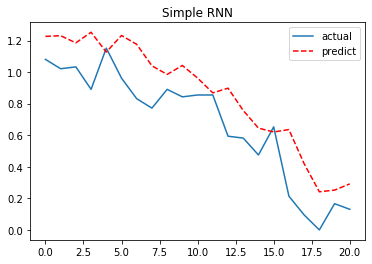

In [72]:
# visualize the result

plt.plot(y_val_single, label="actual")
plt.plot(model.predict(x_val_single), "r", linestyle='--', label="predict")
plt.legend(loc='best')
plt.title('Simple RNN')
plt.savefig("images/text_rnn.png")

print("Test set score: {:.2f}".format(r2_score(y_val_single, model.predict(x_val_single))))

#### RNN-LSTM

In [77]:
# construct the model

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape=x_train_single.shape[-2:]))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), loss='mae') #RMSprop Adam SGD

model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 128)               70144     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 129       
Total params: 70,273
Trainable params: 70,273
Non-trainable params: 0
_________________________________________________________________


In [78]:
# train the model

history = model.fit(train_data_single, epochs=10, steps_per_epoch=200, validation_data=val_data_single, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 6s 30ms/step - loss: 0.2611 - val_loss: 0.5542
Epoch 2/10
200/200 [==============================] - 3s 17ms/step - loss: 0.1195 - val_loss: 0.2372
Epoch 3/10
200/200 [==============================] - 4s 19ms/step - loss: 0.1037 - val_loss: 0.1529
Epoch 4/10
200/200 [==============================] - 4s 19ms/step - loss: 0.0906 - val_loss: 0.1294
Epoch 5/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0785 - val_loss: 0.1331
Epoch 6/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0770 - val_loss: 0.1387
Epoch 7/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0725 - val_loss: 0.1377
Epoch 8/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0679 - val_loss: 0.1411
Epoch 9/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0669 - val_loss: 0.1360
Epoch 10/10
200/200 [===========================

In [79]:
# evaluate the model

model_eval_metrics(y_val_single, model.predict(x_val_single), classification="FALSE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0,0,0,0,0.032838,0.181212,0.136444,0.730349


Test set score: 0.73


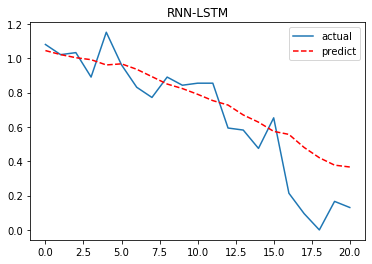

In [80]:
# visualize the result

plt.plot(y_val_single, label="actual")
plt.plot(model.predict(x_val_single), "r", linestyle='--', label="predict")
plt.legend(loc='best')
plt.title('RNN-LSTM')
plt.savefig("images/text_lstm.png")

print("Test set score: {:.2f}".format(r2_score(y_val_single, model.predict(x_val_single))))

#### RNN-LSTM with stacked dropout layers

In [88]:
# construct the model

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape=x_train_single.shape[-2:], return_sequences=True))
model.add(tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(tf.keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(tf.keras.layers.LSTM(16, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(tf.keras.layers.LSTM(8, dropout=0.2, recurrent_dropout=0.2))
#model.add(tf.keras.layers.LSTM(8, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
#model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)))
#model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), loss='mae') #RMSprop Adam SGD

model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 7, 128)            70144     
_________________________________________________________________
lstm_31 (LSTM)               (None, 7, 64)             49408     
_________________________________________________________________
lstm_32 (LSTM)               (None, 7, 32)             12416     
_________________________________________________________________
lstm_33 (LSTM)               (None, 7, 16)             3136      
_________________________________________________________________
lstm_34 (LSTM)               (None, 8)                 800       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 9         
Total params: 135,913
Trainable params: 135,913
Non-trainable params: 0
_______________________________________________

In [89]:
# train the model

history = model.fit(train_data_single, epochs=10, steps_per_epoch=200, validation_data=val_data_single, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 37s 187ms/step - loss: 0.4664 - val_loss: 0.3841
Epoch 2/10
200/200 [==============================] - 10s 49ms/step - loss: 0.2346 - val_loss: 0.1453
Epoch 3/10
200/200 [==============================] - 10s 48ms/step - loss: 0.2148 - val_loss: 0.1132
Epoch 4/10
200/200 [==============================] - 10s 49ms/step - loss: 0.1949 - val_loss: 0.0970
Epoch 5/10
200/200 [==============================] - 10s 48ms/step - loss: 0.1862 - val_loss: 0.0953
Epoch 6/10
200/200 [==============================] - 10s 50ms/step - loss: 0.1774 - val_loss: 0.0960
Epoch 7/10
200/200 [==============================] - 10s 50ms/step - loss: 0.1691 - val_loss: 0.0963
Epoch 8/10
200/200 [==============================] - 11s 53ms/step - loss: 0.1626 - val_loss: 0.0953
Epoch 9/10
200/200 [==============================] - 11s 55ms/step - loss: 0.1542 - val_loss: 0.0973
Epoch 10/10
200/200 [=================

In [90]:
# evaluate the model

model_eval_metrics(y_val_single, model.predict(x_val_single), classification="FALSE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0,0,0,0,0.014221,0.119254,0.094773,0.883219


Test set score: 0.88


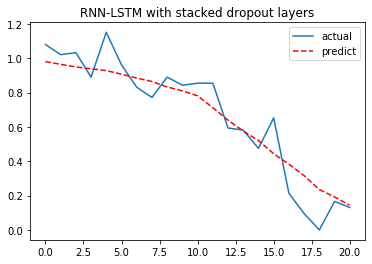

In [91]:
# visualize the result

plt.plot(y_val_single, label="actual")
plt.plot(model.predict(x_val_single), "r", linestyle='--', label="predict")
plt.legend(loc='best')
plt.title('RNN-LSTM with stacked dropout layers')
plt.savefig("images/text_lstm_s.png")

print("Test set score: {:.2f}".format(r2_score(y_val_single, model.predict(x_val_single))))

**Discussion:** Compared to the simple RNN, the RNN-LSTM nowcasts the IBC with a higher test score. This is because the RNN-LSTM can judge how long each information should be kept, and then preserve or forget the memory through the training. Moreover, by adding stacked layers with dropouts, the performance of the RNN-LSTM improves in terms of test scores. This is because the dropout would prevent the overfitting in the training process.

## Method 2: Word Embedding

Using the word embodding instead of Tf-idf vectorizer, this report tries to nowcast whether the IBC increases or decreases from the previous year

In [92]:
# load the IBC data
ibc = pd.read_csv('data/Indexes of Business Conditions.csv', index_col=0)

# create the change rate from the previouse year (Year-over-Year)
ibc['YoY rate'] = 100*ibc['Coincident Index'].pct_change(12)
ibc = ibc.iloc[288:]

# create a dummy variable of YoY (increase = 1, decrease or same = 0)
ibc['YoY dummy'] = 0
for i in range(0,134):
    if ibc['YoY rate'][i] > 0:
        ibc['YoY dummy'][i] = 1
    else:
        ibc['YoY dummy'][i] = 0
        
ibc.head(20)

C:\Users\roomr\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\roomr\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,Coincident Index,YoY rate,YoY dummy
time,,,
Jan-09,75.3,-27.873563,0
Feb-09,69.9,-33.301527,0
Mar-09,69.2,-33.333333,0
Apr-09,70.3,-31.681244,0
May-09,72.2,-29.834791,0
Jun-09,73.3,-26.992032,0
Jul-09,74.0,-25.777332,0
Aug-09,75.7,-21.391485,0
Sep-09,77.9,-18.429319,0


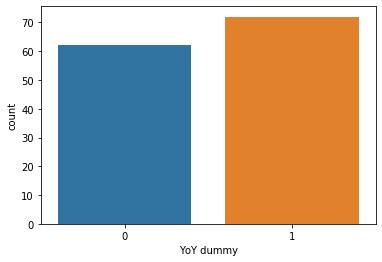

In [93]:
# visualize the YoY dummy variables
ax = sns.countplot(x='YoY dummy', data=ibc)

The binary category is roughly balanced in this data. Thus, the accuracy score would be appricable as metrics

In [94]:
# Tokenize the data into one hot vectors

maxlen = 1000  # cut text after 1000 words
max_words = 10000  # only consider top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(split.body)
sequences = tokenizer.texts_to_sequences(split.body)
word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(ibc["YoY dummy"])

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Set up training and test data
x_train, x_test, y_train, y_test = train_test_split(data, labels, random_state=42)

Found 14236 unique tokens.
Shape of data tensor: (134, 1000)
Shape of label tensor: (134,)


### Nowcasting using RNN-LSTM

In [95]:
# construct the model

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(10000, 128, input_length=maxlen))
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
#model.add(tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
#model.add(tf.keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
#model.add(tf.keras.layers.LSTM(16, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
#model.add(tf.keras.layers.LSTM(8, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
#model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(2, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='binary_crossentropy', metrics=['acc'])

model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 128)         1280000   
_________________________________________________________________
lstm_35 (LSTM)               (None, 1000, 128)         131584    
_________________________________________________________________
flatten (Flatten)            (None, 128000)            0         
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 256002    
Total params: 1,667,586
Trainable params: 1,667,586
Non-trainable params: 0
_________________________________________________________________


In [96]:
# train the model

history = model.fit(x_train, pd.get_dummies(y_train), epochs=10, batch_size=32, validation_split=0.2)

Train on 80 samples, validate on 20 samples
Epoch 1/10
80/80 [==============================] - 11s 140ms/sample - loss: 0.6809 - acc: 0.5250 - val_loss: 0.8584 - val_acc: 0.6000
Epoch 2/10
80/80 [==============================] - 6s 76ms/sample - loss: 0.5486 - acc: 0.6625 - val_loss: 0.5151 - val_acc: 0.7500
Epoch 3/10
80/80 [==============================] - 7s 82ms/sample - loss: 0.1632 - acc: 0.9625 - val_loss: 0.4755 - val_acc: 0.8000
Epoch 4/10
80/80 [==============================] - 6s 78ms/sample - loss: 0.1049 - acc: 0.9625 - val_loss: 0.4865 - val_acc: 0.8000
Epoch 5/10
80/80 [==============================] - 5s 61ms/sample - loss: 0.0802 - acc: 0.9750 - val_loss: 0.5737 - val_acc: 0.7500
Epoch 6/10
80/80 [==============================] - 9s 112ms/sample - loss: 0.0399 - acc: 1.0000 - val_loss: 0.5183 - val_acc: 0.7500
Epoch 7/10
80/80 [==============================] - 7s 85ms/sample - loss: 0.0381 - acc: 0.9875 - val_loss: 0.5756 - val_acc: 0.8000
Epoch 8/10
80/80 [====

In [97]:
# evaluate the result

model.evaluate(x_test, pd.get_dummies(y_test))

34/34 [==============================] - 1s 17ms/sample - loss: 0.4838 - acc: 0.7353


[0.48375461031408873, 0.7352941]

### Nowcasting using Conv1d layers

In [98]:
# construct the model

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(10000, 128, input_length=maxlen))
model.add(tf.keras.layers.Conv1D(64, 7, activation='relu')) 
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(32, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(2, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='binary_crossentropy', metrics=['acc'])

model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 128)         1280000   
_________________________________________________________________
conv1d (Conv1D)              (None, 994, 64)           57408     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 198, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 192, 32)           14368     
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 66        
Total params: 1,351,842
Trainable params: 1,351,842
Non-trainable params: 0
___________________________________________

In [99]:
# train the model

history = model.fit(x_train, pd.get_dummies(y_train), epochs=10, batch_size=32, validation_split=0.2)

Train on 80 samples, validate on 20 samples
Epoch 1/10
80/80 [==============================] - 2s 24ms/sample - loss: 0.7036 - acc: 0.4625 - val_loss: 0.6859 - val_acc: 0.4500
Epoch 2/10
80/80 [==============================] - 1s 15ms/sample - loss: 0.5747 - acc: 0.7000 - val_loss: 0.5865 - val_acc: 0.9000
Epoch 3/10
80/80 [==============================] - 1s 12ms/sample - loss: 0.4805 - acc: 0.8875 - val_loss: 0.5280 - val_acc: 1.0000
Epoch 4/10
80/80 [==============================] - 1s 16ms/sample - loss: 0.4216 - acc: 0.9250 - val_loss: 0.4991 - val_acc: 0.9500
Epoch 5/10
80/80 [==============================] - 1s 10ms/sample - loss: 0.3725 - acc: 0.9500 - val_loss: 0.4882 - val_acc: 0.8500
Epoch 6/10
80/80 [==============================] - 1s 10ms/sample - loss: 0.3261 - acc: 0.9500 - val_loss: 0.4307 - val_acc: 1.0000
Epoch 7/10
80/80 [==============================] - 1s 11ms/sample - loss: 0.2821 - acc: 0.9750 - val_loss: 0.4537 - val_acc: 0.8500
Epoch 8/10
80/80 [=======

In [100]:
# evaluate the model

model.evaluate(x_test, pd.get_dummies(y_test))

34/34 [==============================] - 0s 2ms/sample - loss: 0.5022 - acc: 0.7941


[0.5021577477455139, 0.7941176]

**Discussion:** The word embedding with RNN-LSTM and Conv1d layers classifies the increases or decreases in the change rates of IBC to some extent, although the test accuracies are not so high. In this dataset, the Conv1d layers work better than the RNN-LSTM in terms of accuracy (0.79 vs. 0.74).